# AGCD Rx1day and Rx5day

Rainfall extremes (rx1day; maximum day of the year) in Australia.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LatitudeFormatter, LongitudeFormatter
import cmocean
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.dates import set_epoch
import numpy as np
# import pandas as pd
from pathlib import Path
from scipy.stats import genextreme
import xarray as xr

from unseen.eva import fit_gev

In [3]:
home = Path("/g/data/xv83/unseen-projects/outputs/tc-jasper")

# Plot maps of Rx1day and Rx5day over Australia (maximum and median).

In [4]:
def plot_aus_map(
    ax, data, title=None, label="", outfile=False, cbar_kwargs=dict(fraction=0.05, extend="max"), cmap=cmocean.cm.rain, **kwargs
):
    """Plot 2D data on an Australia map with coastlines.

    Parameters
    ----------
    ax : matplotlib plot axis
    data : xarray DataArray
        2D data to plot
    title : str, optional
        Title for the plot
    label : str, optional
        Label for the colorbar
    outfile : str, optional
        Filename for the plot
    cmap : matplotlib colormap, default cmocean.cm.rain
    **kwargs : optional
        Additional keyword arguments for pcolormesh

    Returns
    -------
    ax : matplotlib plot axis
    """
    ax.coastlines()
    if title is not None:
        ax.set_title(title, loc="left")

    cs = ax.pcolormesh(data.lon, data.lat, data, cmap=cmap, **kwargs)
    cbar = fig.colorbar(cs, label=label, **cbar_kwargs)

    # Format ticks
    xticks = np.arange(115, 155, 5)
    yticks = np.arange(-40, -10, 5)

    ax.set_xticks(xticks)
    ax.set_yticks(yticks)
    ax.yaxis.set_major_formatter(LatitudeFormatter())
    ax.xaxis.set_major_formatter(LongitudeFormatter())
    ax.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.tick_params(
        axis="both",
        which="both",
        direction="in",
        bottom=True,
        top=True,
        left=True,
        right=True,
    )
    ax.add_feature(cartopy.feature.OCEAN, zorder=1)

    if outfile:
        plt.tight_layout()
        plt.savefig(outfile, dpi=200)
        plt.show()
    return ax

In [5]:
# Mask ocean and poor data regions.
mask = xr.open_mfdataset(home / "data/land_poordata_mask_0.05.nc")
mask = mask.mask.rename(dict(latitude="lat", longitude="lon"))
mask = mask.sel(lon=slice(112, 156), lat=slice(-45, -10))

# Rx5day map

In [6]:
ds = xr.open_dataset(
    home / "data/rx5day_AGCD-CSIRO_1901-2024_annual-aug-to-sep.zarr.zip", engine="zarr"
)

ds = ds.where(mask != 0)
ds = ds.dropna("time", how="all").dropna("lat", how="all").dropna("lon", how="all")
ds["pr"].attrs["name"] = "Rx5day"
ds["pr"].attrs["units"] = "mm"
ds

<xarray.Dataset>
Dimensions:  (time: 123, lat: 641, lon: 808)
Coordinates:
  * lat      (lat) float32 -43.6 -43.55 -43.5 -43.45 ... -10.85 -10.8 -10.75
  * lon      (lon) float32 113.2 113.3 113.3 113.4 ... 153.4 153.5 153.6 153.6
  * time     (time) datetime64[ns] 1901-01-01T09:00:00 ... 2023-01-01T09:00:00
Data variables:
    pr       (time, lat, lon) float32 dask.array<chunksize=(123, 641, 808), meta=np.ndarray>
Attributes: (12/33)
    CDI:                           Climate Data Interface version ?? (http://...
    CDO:                           Climate Data Operators version 1.7.0 (http...
    Conventions:                   CF-1.6
    acknowledgment:                The Australian Government, Bureau of Meteo...
    analysis_components:           total: the gridded accumulation of rainfall.
    bom-cmp-awap_version:          bom-cmp-awap-1.00-89.0.x86_64
    ...                            ...
    summary:                       The daily and monthly rainfall data repres...
    time_coverage_end:             1900-01-01T09:00:00
    time_coverage_start:           1899-12-31T09:00:00
    title:                         Interpolated Rain Gauge Precipitation
    url:                           http://www.bom.gov.au/climate/
    uuid:                          14333ae2-28fe-4cb6-9f00-677adc94f25e

In [7]:
ds1 = xr.open_dataset(
    home / "data/rx1day_AGCD-CSIRO_1901-2024_annual-aug-to-sep.zarr.zip", engine="zarr"
)

ds1 = ds1.where(mask != 0)
ds1 = ds1.dropna("time", how="all").dropna("lat", how="all").dropna("lon", how="all")

In [8]:
cmap = cmocean.cm.rain
cmap.set_bad("white")

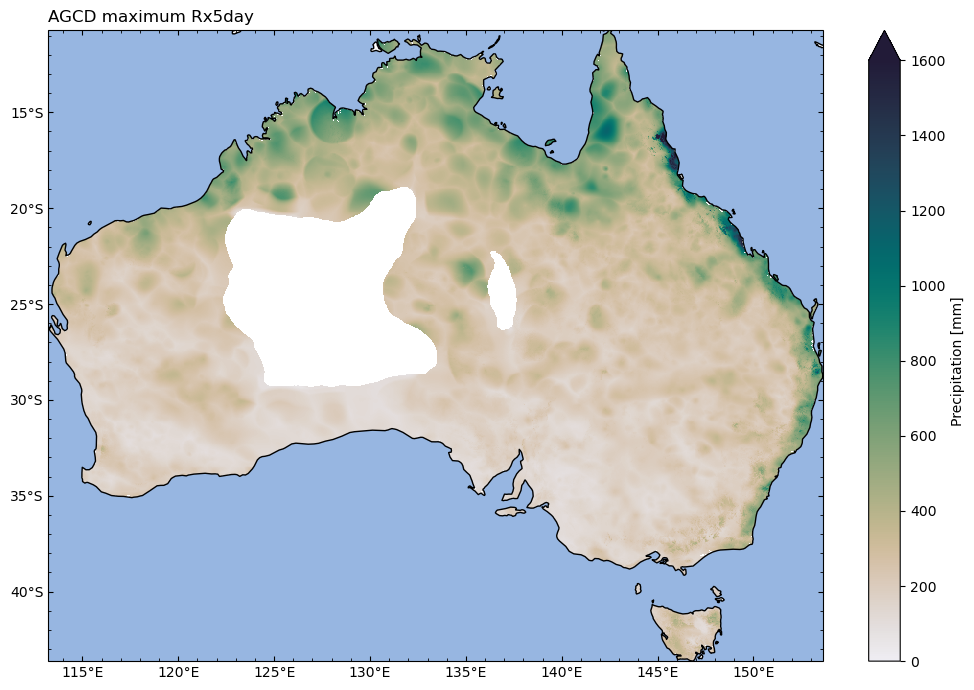

/g/data/e14/as3189/conda/envs/unseen/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


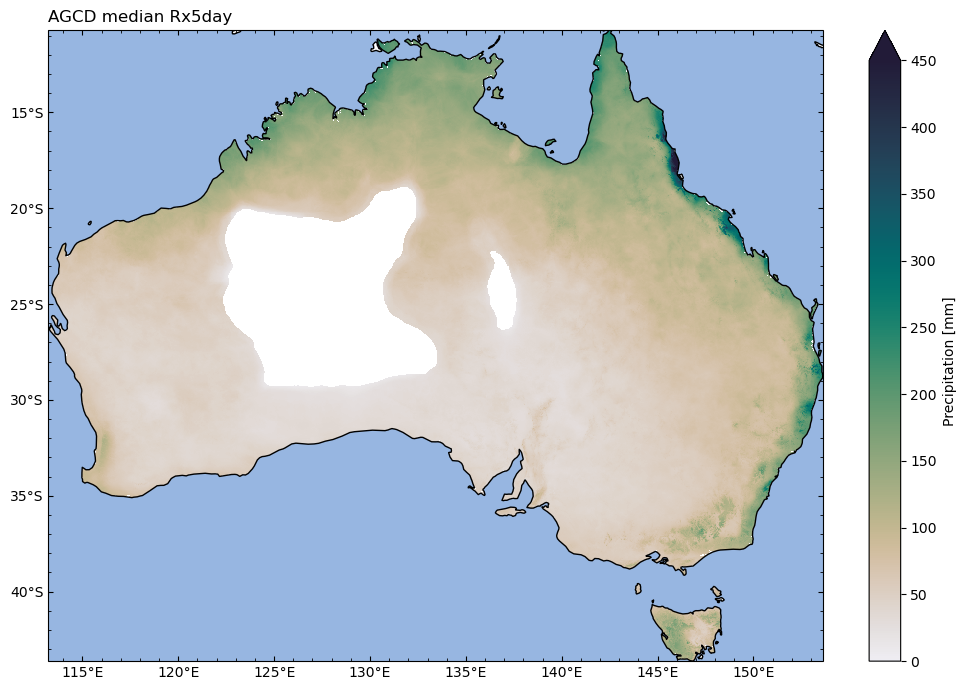

In [9]:
dx = ds.pr.max("time")
fig = plt.figure(figsize=(10, 7))
ax = plt.axes(projection=ccrs.PlateCarree(), frameon=True)
ax = plot_aus_map(
    ax,
    dx,
    title="AGCD maximum Rx5day",
    label="Precipitation [mm]",
    outfile=home / "figures/rx5day_maximum_map_AGCD-CSIRO.png",
    cbar_kwargs=dict(fraction=0.05, extend="max"),
    cmap=cmap,
    vmin=0,
    vmax=1600,
    # norm=mpl.colors.LogNorm(vmin=max(dx.min().load(), 0), vmax=dx.max().load()),
)

dx = ds.pr.median("time")
fig = plt.figure(figsize=(10, 7))
ax = plt.axes(projection=ccrs.PlateCarree(), frameon=True)
ax = plot_aus_map(
    ax,
    dx,
    title="AGCD median Rx5day",
    label="Precipitation [mm]",
    outfile=home / "figures/rx5day_median_map_AGCD-CSIRO.png",
    cmap=cmap,
    cbar_kwargs=dict(fraction=0.05, extend="max"),
    vmin=0,
    vmax=450,
)

/g/data/e14/as3189/conda/envs/unseen/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


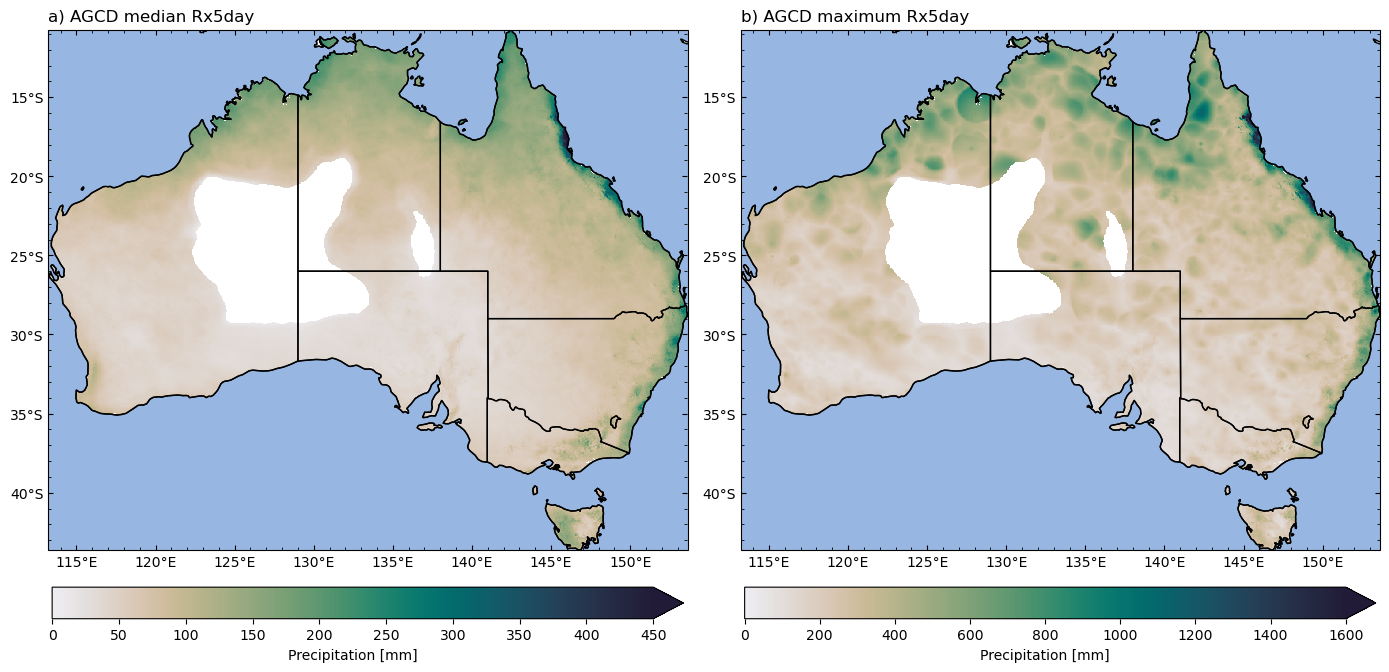

In [49]:
fig, ax = plt.subplots(1, 2, figsize=(14, 10), subplot_kw=dict(projection=ccrs.PlateCarree()))
ax = ax.flatten()

ax[0] = plot_aus_map(
    ax[0],
    ds.pr.median("time"),
    title="a) AGCD median Rx5day",
    label="Precipitation [mm]",
    cbar_kwargs=dict(orientation="horizontal", fraction=0.034, extend="max", pad=0.04),
    cmap=cmap,
    vmin=0,
    vmax=450,
)
ax[1] = plot_aus_map(
    ax[1],
    ds.pr.max("time"),
    title="b) AGCD maximum Rx5day",
    label="Precipitation [mm]",
    cbar_kwargs=dict(orientation="horizontal", fraction=0.034, extend="max", pad=0.04),
    cmap=cmap,
    vmin=0,
    vmax=1600,
)
plt.tight_layout()
plt.savefig(home / "figures/rx5day_map_AGCD-CSIRO.png", dpi=200)
plt.show()

# Rx1day Map

/g/data/e14/as3189/conda/envs/unseen/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


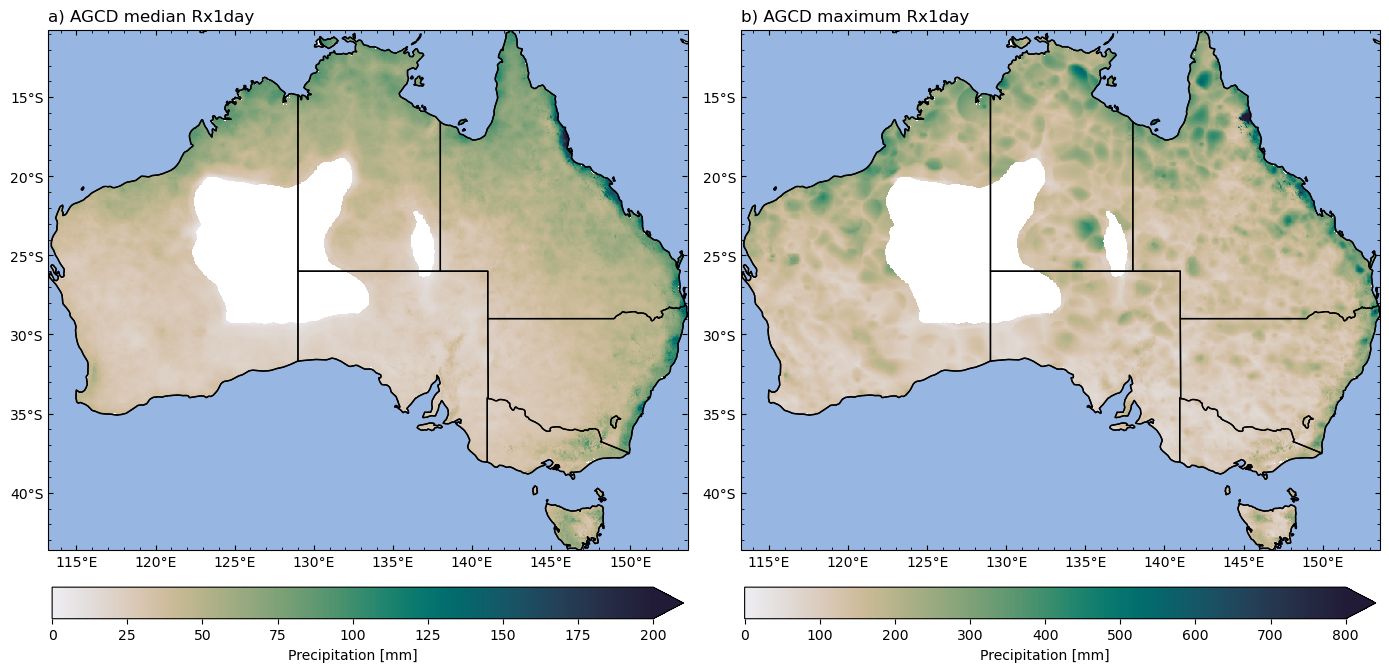

In [48]:
fig, ax = plt.subplots(1, 2, figsize=(14, 10), subplot_kw=dict(projection=ccrs.PlateCarree()))
ax = ax.flatten()

ax[0] = plot_aus_map(
    ax[0],
    ds1.pr.median("time"),
    title="a) AGCD median Rx1day",
    label="Precipitation [mm]",
    cbar_kwargs=dict(orientation="horizontal", fraction=0.034, extend="max", pad=0.04),
    cmap=cmap,
    vmin=0,
    vmax=200,
)
ax[1] = plot_aus_map(
    ax[1],
    ds1.pr.max("time"),
    title="b) AGCD maximum Rx1day",
    label="Precipitation [mm]",
    cbar_kwargs=dict(orientation="horizontal", fraction=0.034, extend="max", pad=0.04),
    cmap=cmap,
    vmin=0,
    vmax=800,
)
for i in range(2):
    ax[i].add_feature(cartopy.feature.STATES, zorder=10)
plt.tight_layout()
plt.savefig(home / "figures/rx1day_map_AGCD-CSIRO.png", dpi=200)
plt.show()

# Daintree, Myola and Cairns analysis

In [27]:
coords = [[-16.8, 145.6], [-16.95, 145.8]]
# N.B. Cairns coordinate is masked by poordata mask
name = ["Myola", "Cairns"]

In [16]:
# Daintree region 
dx = xr.open_dataset(
    home / "data/rx5day_AGCD-CSIRO_1901-2024_annual-aug-to-sep_daintree-river.nc"
)
dx = dx.dropna("time", how="all")
dx["pr"].attrs["name"] = "Rx5day"
dx["pr"].attrs["units"] = "mm"
dx

<xarray.Dataset>
Dimensions:     (time: 123)
Coordinates:
  * time        (time) datetime64[ns] 1901-01-01T09:00:00 ... 2023-01-01T09:0...
    event_time  (time) object ...
Data variables:
    pr          (time) float32 222.2 161.0 1.268e+03 527.7 ... 301.2 400.0 296.5
Attributes: (12/33)
    CDI:                           Climate Data Interface version ?? (http://...
    history:                       Wed Mar 06 14:05:54 2024: /g/data/xv83/dbi...
    institution:                   Australian Bureau of Meteorology, GPO Box ...
    Conventions:                   CF-1.6
    geospatial_lat_min:            -44.525
    geospatial_lat_max:            -9.975
    ...                            ...
    url:                           http://www.bom.gov.au/climate/
    licence:                       Copyright for any data supplied by the Bur...
    id:                            Australian Gridded Climate Data (AGCD)
    summary:                       The daily and monthly rainfall data repres...
    naming_authority:              au.gov.bom
    CDO:                           Climate Data Operators version 1.7.0 (http...

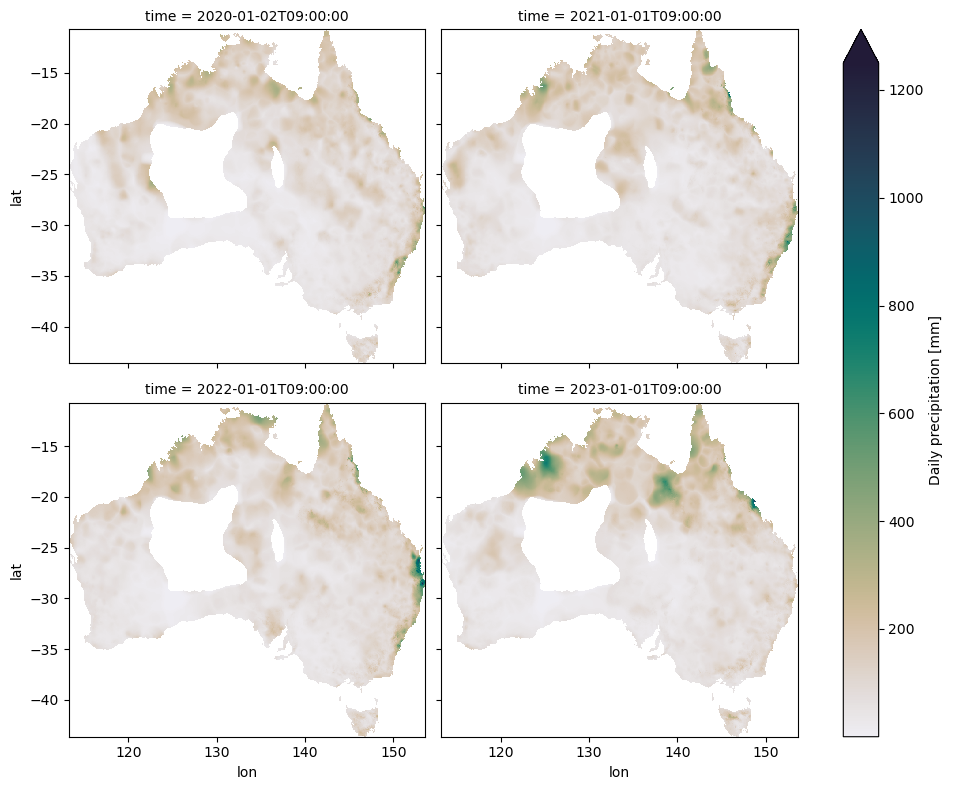

In [17]:
ds.pr.sel(time=slice("2020-01-01", "2025-01-01")).plot(figsize=[10, 8], col="time", col_wrap=2, cmap=cmocean.cm.rain, vmax=1250)

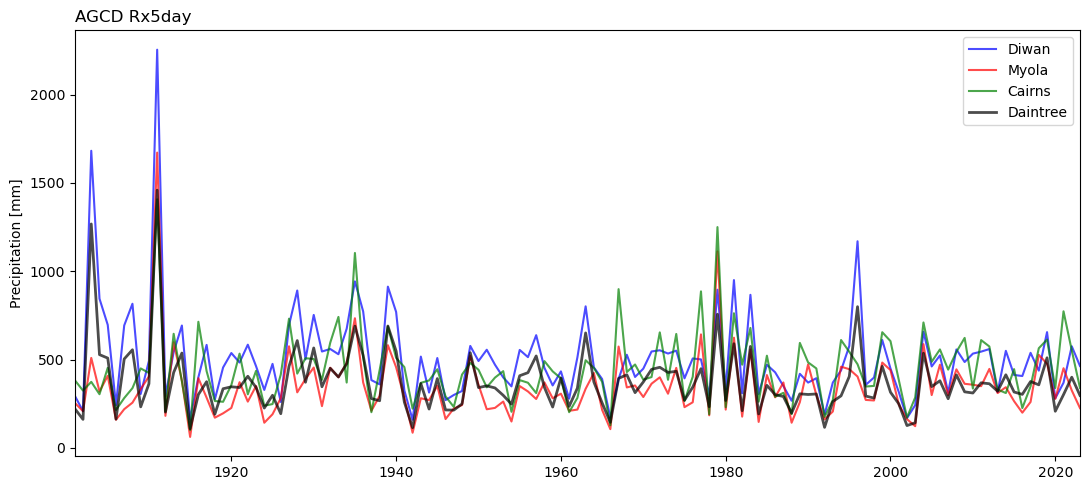

In [19]:
# Plot time series of Daintree, Myola and Cairns Rx5day.
fig, ax = plt.subplots(1, 1, figsize=(11, 5))
ax.set_title("AGCD Rx5day".format(name), loc="left")
for i in range(len(coords)):
    ax.plot(
        ds.time.dt.year,
        ds.pr.sel(lat=coords[i][0], lon=coords[i][1], method="nearest"),
        color=["b", "r", "g"][i],
        label=name[i],
        alpha=0.7,
    )
ax.plot(
    dx.time.dt.year,
    dx.pr,
    color="k",
    label="Daintree",
    alpha=0.7,
    lw=2,
)
ax.set_xmargin(0)
ax.legend()
ax.set_ylabel("Precipitation [mm]")
plt.tight_layout()
# plt.savefig(home / "figures/rx5day_timeseries_AGCD-CSIRO.png")

In [21]:
ranked_years = ds.to_dataframe().sort_values(by="pr", ascending=False)
print(ranked_years.head(n=20))

                                                    pr
time                lat        lon                    
1903-01-01 09:00:00 -16.250000 145.000000  2828.835938
                    -16.200001 145.000000  2594.188477
                    -16.450001 145.199997  2583.677734
                    -16.299999 145.000000  2571.223633
1911-01-01 09:00:00 -16.450001 145.199997  2506.518555
1903-01-01 09:00:00 -16.250000 145.050003  2471.715820
1911-01-01 09:00:00 -16.450001 145.250000  2385.147461
                    -16.200001 145.399994  2254.940430
                    -16.500000 145.250000  2245.318359
1903-01-01 09:00:00 -16.450001 145.250000  2227.080078
                    -16.250000 144.949997  2179.376953
1911-01-01 09:00:00 -16.250000 145.399994  2172.013672
                    -16.400000 145.250000  2161.041016
                    -16.250000 145.350006  2158.669922
1903-01-01 09:00:00 -16.400000 145.250000  2136.004883
                    -16.350000 145.199997  2129.748047
          

In [22]:
rx5day_max = ranked_years.iloc[0]["pr"]
print(rx5day_max)

2828.836


# Distribution parameters

In [28]:
i = 0
data = ds.pr.sel(lat=coords[i][0], lon=coords[i][1], method="nearest").load()

In [43]:
# Calculate stationary parameters
shape, loc, scale = fit_gev(dx.pr, stationary=True, check_fit=True)
print(shape, loc, scale)

nan nan nan


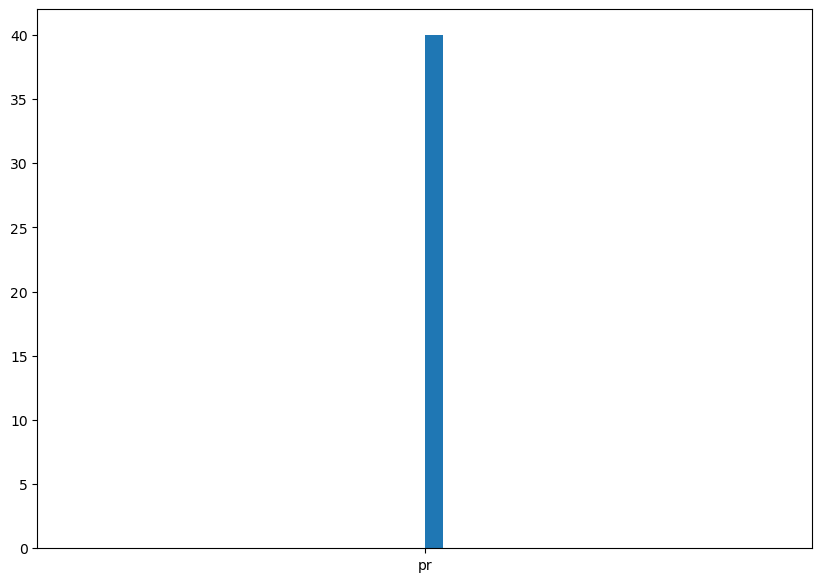

In [44]:
# Plot histogram and distribution
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
_, bins, _ = ax.hist(dx, bins=40, density=True)
pdf_genext = genextreme.pdf(bins, shape, loc=loc, scale=scale)
ax.plot(bins, pdf_genext, c="k")

In [31]:
event_probability = genextreme.sf(1400, shape, loc=loc, scale=scale)
event_return_period = 1.00 / event_probability
event_percentile = (1 - event_probability) * 100

print(f"{event_return_period:.0f} year return period")
print(f"{event_percentile:.2f}% percentile\n")

1108 year return period
99.91% percentile



# Nonstationary GEV

In [32]:
def non_stationary_gev_multi_plot(
    data,
    theta,
    covariate,
    covar_inds=None,
    ds_obs=None,
    outfile=None,
    title="",
    ylabel="",
    **kwargs
):
    """Plot timeseries, histogram & PDF fit and return values.

    Parameters
    ----------
    data : xarray.DataArray
        Time series of data to fit.
    theta : tuple
        Non-stationary GEV parameters (shape, loc0, loc1, scale0, scale1).
    covariate : np.ndarray
        Covariate values to use for non-stationary fit.
    covar_inds : np.ndarray, optional
        Indices of covariate to use for plotting. If None, every 4th value is used.
    ds_obs : xarray.Dataset, optional
        Observations to overlay on timeseries.
    outfile : str, optional
        File to save plot to.
    title : str, optional
        Title to use for plot.
    **kwargs : dict
        Additional keyword arguments to pass to fit_gev.

    """
    # Non-stationary GEV parameters.
    shape, loc0, loc1, scale0, scale1 = theta

    # Distribution parameters from genextremes using default args
    theta_genex = fit_gev(data, stationary=True, generate_estimates=True, **kwargs)
    shape_genext, loc_genext, scale_genext = theta_genex
    print("Stationary fit: c={: .4f}, μ={:.4f}, σ={:.4f}".format(*theta_genex))
    print("c={: .4f}, μ0={:.4f}, μ1={:.4f} σ0={:.4f}, σ1={:.4f}".format(*theta))

    da = data.unstack()
    time_dim = kwargs.get("time_dim", "time")
    if covariate is None:
        covariate = np.arange(data[time_dim].size)
    if covar_inds is None:
        covar_inds = covariate[:: len(covariate) // 4]  # pick n t values

    n = len(covar_inds)
    colors = plt.cm.rainbow(np.linspace(0, 1, n + 1))

    loc = loc0 + loc1 * covar_inds
    scale = scale0 + scale1 * covar_inds

    fig, axes = plt.subplot_mosaic(
        "AA;BC", figsize=(12, 7), gridspec_kw={"height_ratios": [0.8, 1]}
    )
    ax = [axes[i] for i in ["A", "B", "C"]]

    # Subplot 1: Data timeseries bar graph
    ax[0].set_title("a) " + title, loc="left")
    ax[0].bar(data.time.dt.year, data, color="b")
    ax[0].set_ylabel(ylabel)

    # Observations
    if ds_obs is not None:
        ax[0].plot(ds_obs.time.dt.year, ds_obs, color="k")

    # # Change to scatter (10 ensembles per year)
    # ax2 = ax[0].twiny()
    # # xx = np.repeat(da.ensemble, np.unique(da.init_date.dt.year).size)
    # ax2.scatter(da.init_date.dt.year, da, c="b", lw=1, alpha=0.7, s=8)
    # ax2.set_xticks([])

    # Subplot 2: histogram and PDFs.
    # Histogram.
    _, b, _ = ax[1].hist(data, bins=40, density=True, alpha=0.5, label="Histogram")
    ax[1].set_title("b) Data histogram and PDF", loc="left")

    # Stationary GEV fit
    pdf_genext = genextreme.pdf(b, shape_genext, loc=loc_genext, scale=scale_genext)
    ax[1].plot(b, pdf_genext, c="k", ls="--", lw=2, label="Stationary fit")

    # Nonstationary GEV fit
    for i, t in enumerate(covar_inds):
        pdf_nsgev = genextreme.pdf(b, shape, loc=loc[i], scale=scale[i])
        ax[1].plot(b, pdf_nsgev, lw=1.5, c=colors[i], zorder=0, label="t={}".format(t))
    ax[1].set_ylabel("Probability")
    ax[1].legend(bbox_to_anchor=(0.99, 0.99), loc=1)

    # Subplot 3: Return curves
    return_periods = np.arange(0, data.size, 2)
    return_levels = genextreme.isf(
        1 / return_periods, shape_genext, loc_genext, scale_genext
    )
    ax[2].set_title("c) Return values", loc="left")
    ax[2].plot(
        return_levels,
        return_periods,
        label="Stationary fit",
        c="k",
        ls="--",
        zorder=n + 1,
    )

    for i, t in enumerate(covar_inds):
        return_levels = genextreme.isf(1 / return_periods, shape, loc[i], scale[i])
        ax[2].plot(return_levels, return_periods, label="t={}".format(t), c=colors[i])

    ax[2].set_xlabel("Return period")
    ax[2].set_ylabel(ylabel)

    for i in range(3):
        ax[i].yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
        ax[i].xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
        ax[i].set_xmargin(1e-2)
    # @todo: add bounds shading
    plt.tight_layout()
    if outfile:
        plt.savefig(outfile, dpi=220)
    plt.show()

Myola [-9.35143198e-02 -3.39456180e+02  3.07933618e-01  5.24195775e+02
 -2.08557886e-01]
Stationary fit: c=-0.0893, μ=264.6884, σ=116.5248
c=-0.0935, μ0=-339.4562, μ1=0.3079 σ0=524.1958, σ1=-0.2086


/jobfs/111069529.gadi-pbs/ipykernel_3339831/1609681376.py:95: RuntimeWarning: divide by zero encountered in divide
  1 / return_periods, shape_genext, loc_genext, scale_genext
/jobfs/111069529.gadi-pbs/ipykernel_3339831/1609681376.py:108: RuntimeWarning: divide by zero encountered in divide
  return_levels = genextreme.isf(1 / return_periods, shape, loc[i], scale[i])


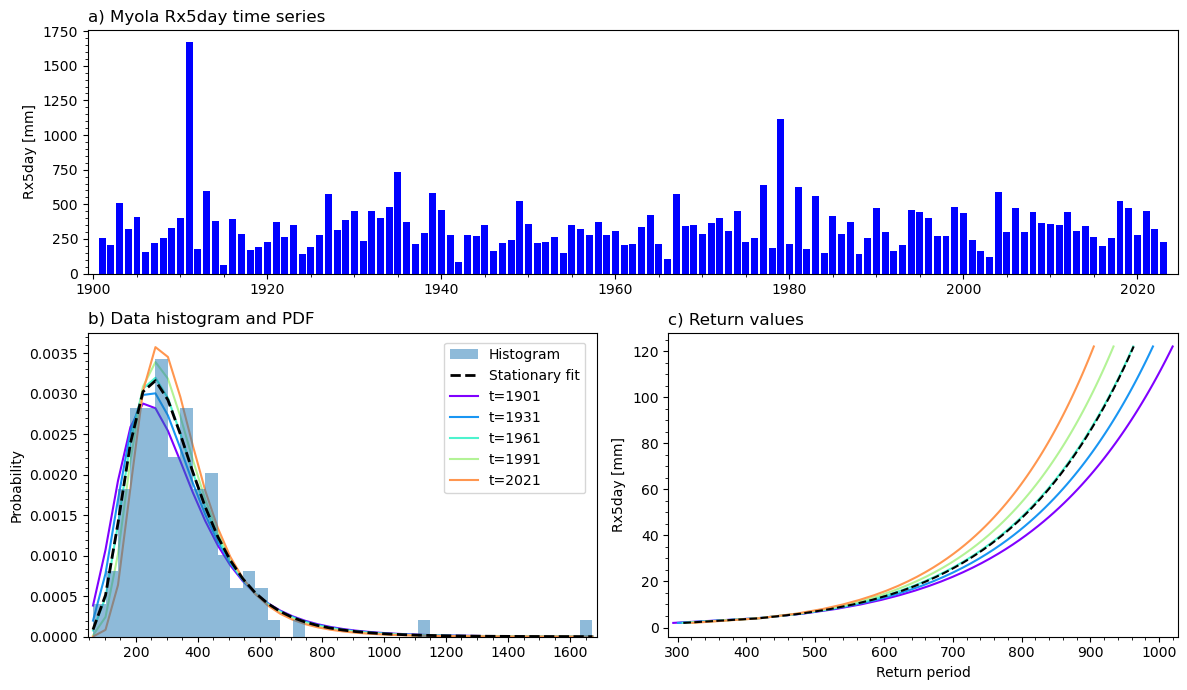

Cairns [-4.67048829e-02 -5.77901647e+02  4.75080079e-01  0.00000000e+00
  7.43833418e-02]


/g/data/xv83/as3189/unseen/unseen/eva.py:286: UserWarning: Data fit failed.
  warnings.warn("Data fit failed.")


Stationary fit: c= nan, μ=nan, σ=nan
c=-0.0467, μ0=-577.9016, μ1=0.4751 σ0=0.0000, σ1=0.0744


/jobfs/111069529.gadi-pbs/ipykernel_3339831/1609681376.py:95: RuntimeWarning: divide by zero encountered in divide
  1 / return_periods, shape_genext, loc_genext, scale_genext
/jobfs/111069529.gadi-pbs/ipykernel_3339831/1609681376.py:108: RuntimeWarning: divide by zero encountered in divide
  return_levels = genextreme.isf(1 / return_periods, shape, loc[i], scale[i])


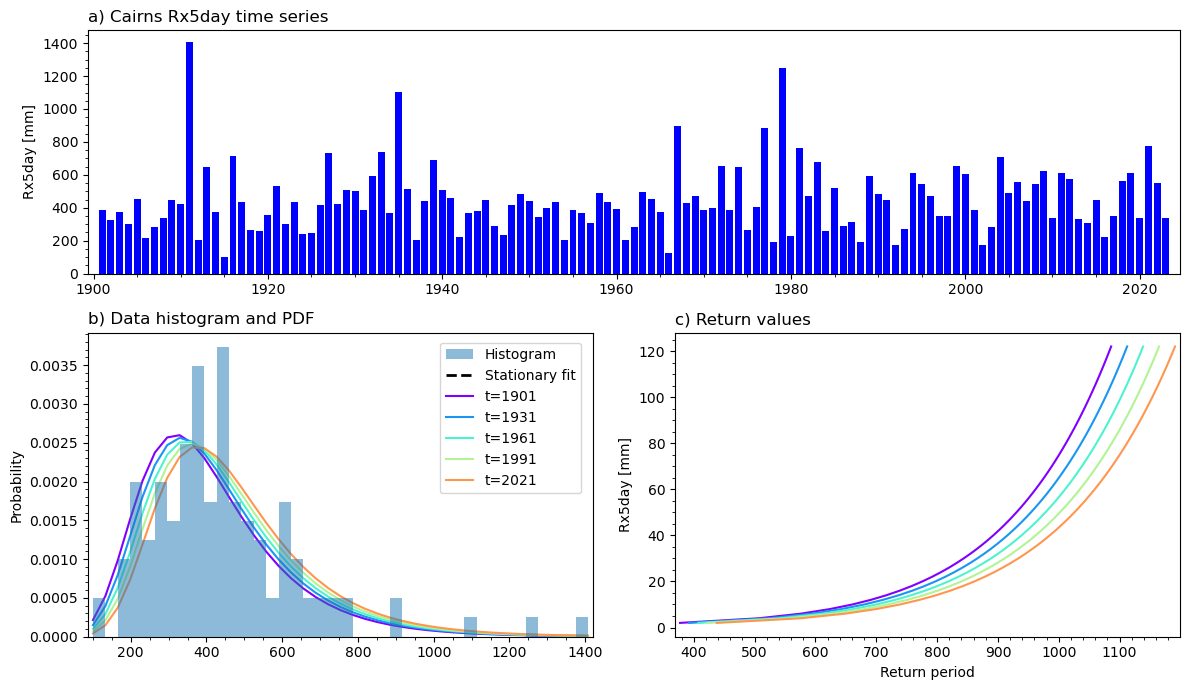

In [35]:
for i in range(len(coords)):
    data = ds.pr.sel(lat=coords[i][0], lon=coords[i][1])
    covariate = data.time.dt.year
    theta = fit_gev(data, covariate=covariate, stationary=False, check_relative_fit="lrt")
    non_stationary_gev_multi_plot(
        data,
        theta,
        covariate=covariate.values,
        title=f"{name[i]} Rx5day time series",
        ylabel="Rx5day [mm]",
        outfile=home / f"figures/rx5day_AGCD-CSIRO_ns_gev_{name[i]}.png",
    )

Stationary fit: c=-0.0893, μ=264.6884, σ=116.5248
c=-0.0935, μ0=-339.4562, μ1=0.3079 σ0=524.1958, σ1=-0.2086


/jobfs/111069529.gadi-pbs/ipykernel_3339831/1609681376.py:95: RuntimeWarning: divide by zero encountered in divide
  1 / return_periods, shape_genext, loc_genext, scale_genext
/jobfs/111069529.gadi-pbs/ipykernel_3339831/1609681376.py:108: RuntimeWarning: divide by zero encountered in divide
  return_levels = genextreme.isf(1 / return_periods, shape, loc[i], scale[i])


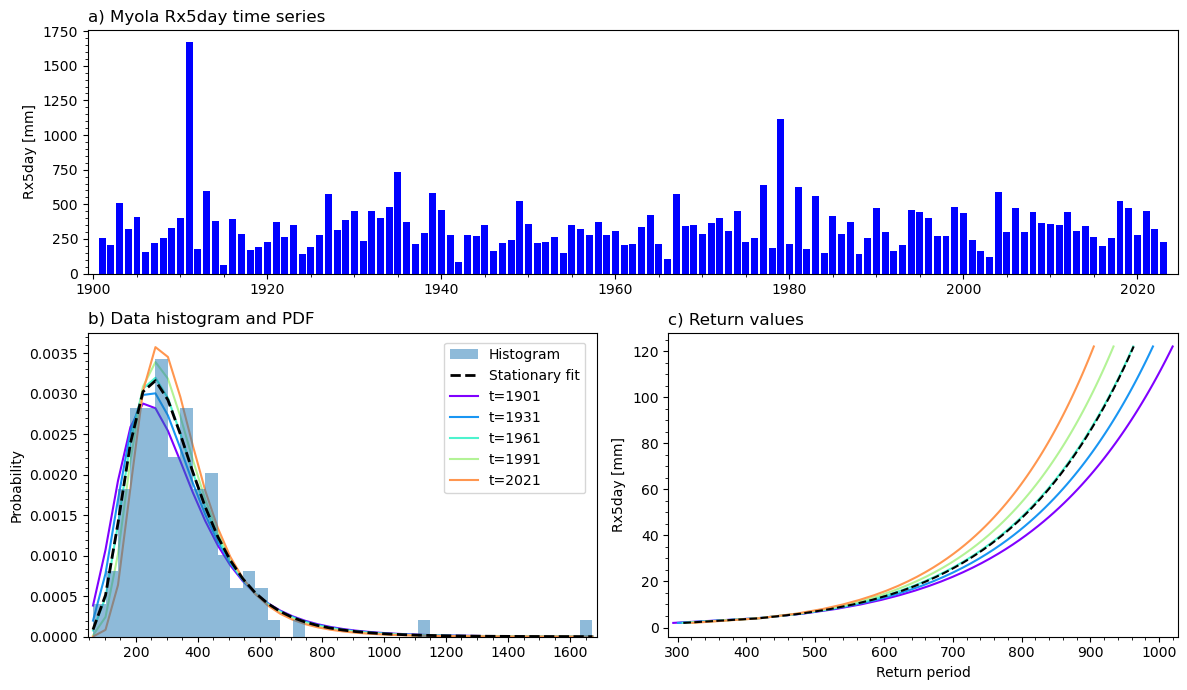

/g/data/xv83/as3189/unseen/unseen/eva.py:286: UserWarning: Data fit failed.
  warnings.warn("Data fit failed.")


Stationary fit: c= nan, μ=nan, σ=nan
c=-0.0467, μ0=-577.9016, μ1=0.4751 σ0=0.0000, σ1=0.0744


/jobfs/110852423.gadi-pbs/ipykernel_2027130/1609681376.py:95: RuntimeWarning: divide by zero encountered in divide
  1 / return_periods, shape_genext, loc_genext, scale_genext
/jobfs/110852423.gadi-pbs/ipykernel_2027130/1609681376.py:108: RuntimeWarning: divide by zero encountered in divide
  return_levels = genextreme.isf(1 / return_periods, shape, loc[i], scale[i])


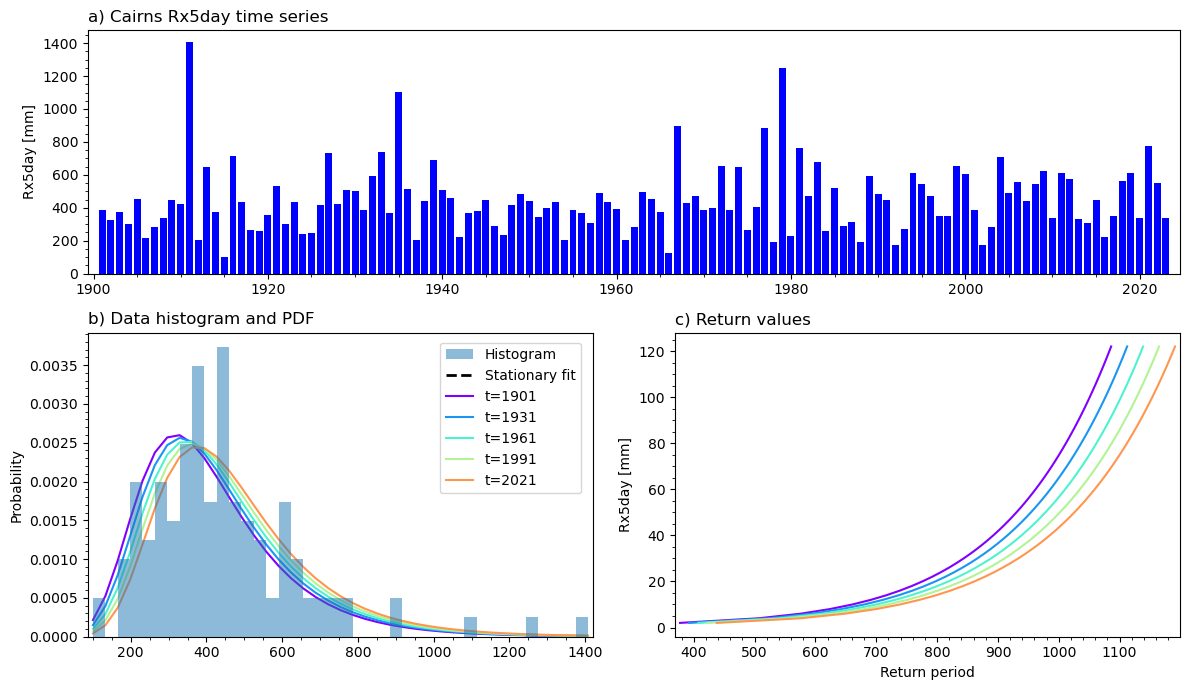

In [61]:
# Cairns
i = 2
data = ds.pr.sel(lat=coords[i][0], lon=coords[i][1])
covariate = data.time.dt.year
theta1 = fit_gev(data, covariate=covariate, stationary=False, check_relative_fit="lrt")
non_stationary_gev_multi_plot(
    data,
    theta1,
    covariate=covariate.values,
    title=f"{name[i]} Rx5day time series",
    ylabel="Rx5day [mm]",
    outfile=home / f"figures/rx5day_AGCD-CSIRO_ns_gev_{name[i]}.png",
)

Stationary fit: c= nan, μ=nan, σ=nan
c= 7.3923, μ0=108.6675, μ1=0.0000 σ0=2.5366, σ1=0.0000


/jobfs/110852423.gadi-pbs/ipykernel_2027130/1609681376.py:95: RuntimeWarning: divide by zero encountered in divide
  1 / return_periods, shape_genext, loc_genext, scale_genext
/jobfs/110852423.gadi-pbs/ipykernel_2027130/1609681376.py:108: RuntimeWarning: divide by zero encountered in divide
  return_levels = genextreme.isf(1 / return_periods, shape, loc[i], scale[i])


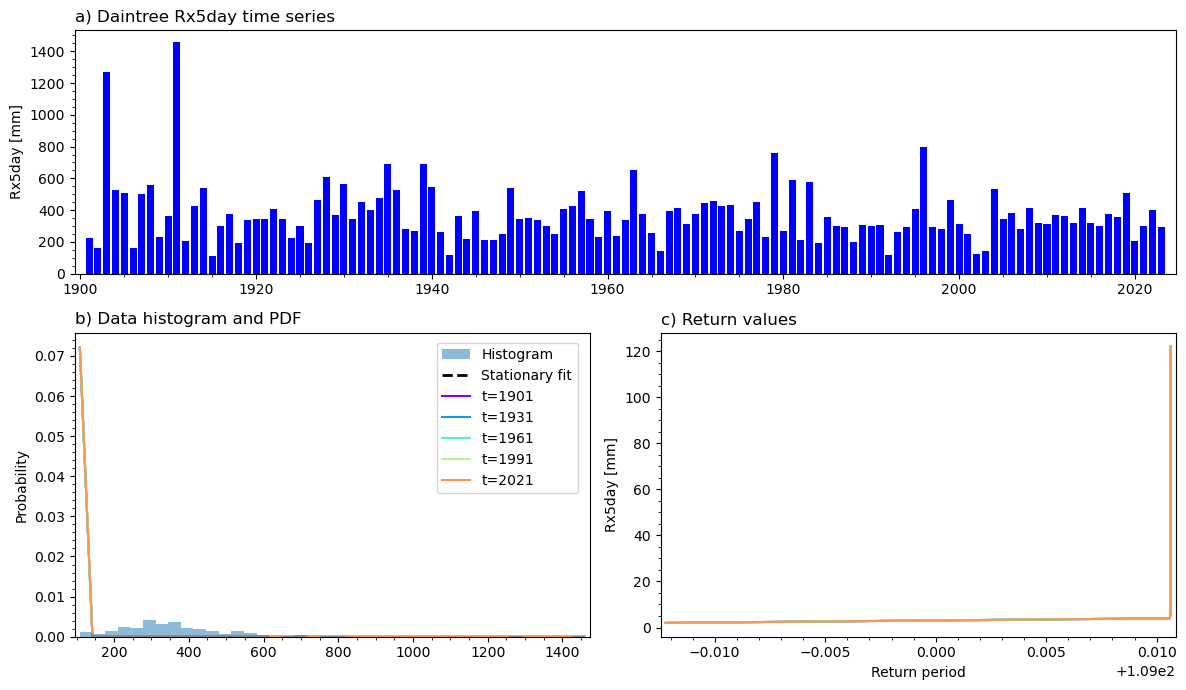

In [60]:
# Daintree regions
covariate2 = dx.time.dt.year.values
theta2 = fit_gev(dx.pr, covariate=covariate2, stationary=False, check_relative_fit="lrt")
non_stationary_gev_multi_plot(
    dx.pr,
    theta2,
    covariate=covariate2,
    title=f"Daintree Rx5day time series",
    ylabel="Rx5day [mm]",
    outfile=home / f"figures/rx5day_AGCD-CSIRO_ns_gev_Daintree.png",
)

# 100-year return maps

In [ ]:
# ds = ds.pr.where(mask != 0)
# data = ds.dropna("time", how="all").dropna("lat", how="all").dropna("lon", how="all")

# # data = data.sel(lat=slice(-30, -20), lon=slice(135, 145))  # !!!
# covariate = data.time.dt.year.values

# start_time = time.time()
# theta = fit_gev(
#     data,
#     covariate=covariate,
#     stationary=False,
#     generate_estimates=True,
#     check_fit=False,
#     check_relative_fit="lrt",
# )

In [ ]:
# theta = theta.to_dataset(name="theta")

# theta_file = home / "data/rx5day_theta_AGCD-CSIRO_1901-2024_annual-aug-to-sep_lrt.nc"
# theta.to_netcdf(theta_file, compute=True)

In [36]:
method = "lrt"
theta_file = home / f"data/rx5day_theta_AGCD-CSIRO_1901-2024_annual-aug-to-sep_{method}.nc"
theta = xr.open_dataset(theta_file)
theta = theta.theta
theta

<xarray.DataArray 'theta' (lat: 641, lon: 808, theta: 5)>
[2589640 values with dtype=float64]
Coordinates:
  * lat      (lat) float32 -43.6 -43.55 -43.5 -43.45 ... -10.85 -10.8 -10.75
  * lon      (lon) float32 113.2 113.3 113.3 113.4 ... 153.4 153.5 153.6 153.6
    theta    (lat, lon, theta) float64 ...

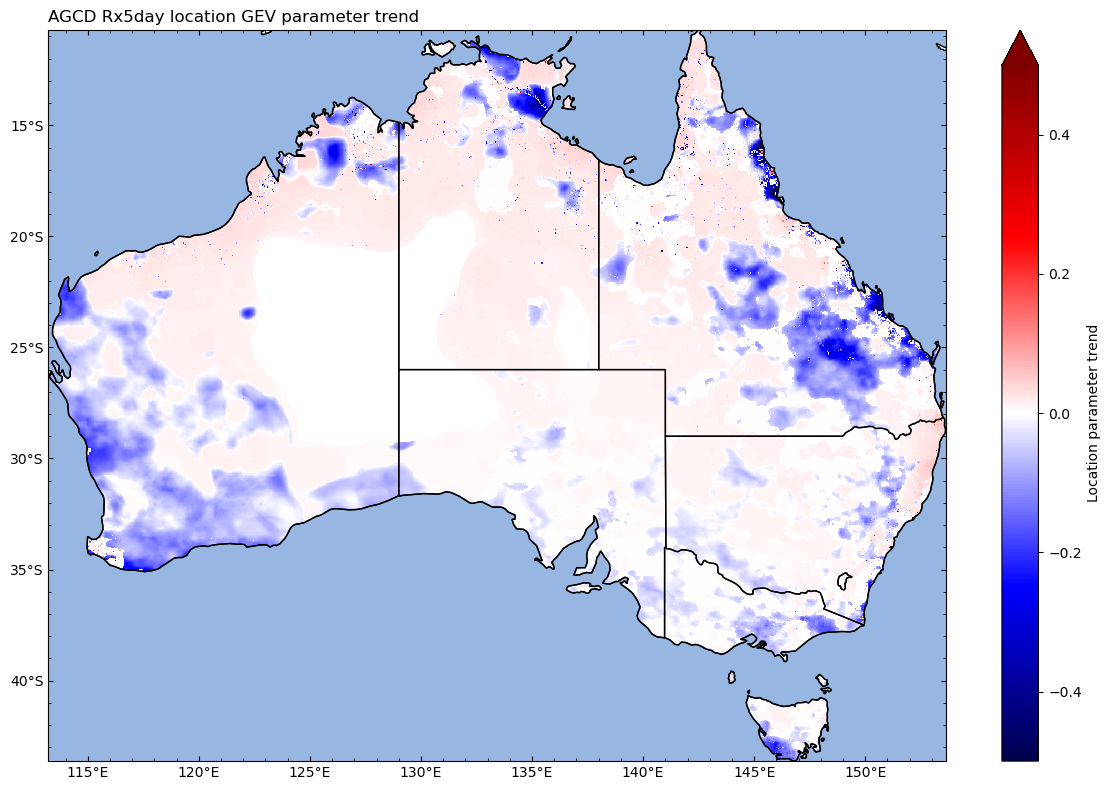

In [47]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8), subplot_kw=dict(projection=ccrs.PlateCarree()))
ax.add_feature(cartopy.feature.STATES, zorder=10)
ax = plot_aus_map(
    ax,
    theta.isel(theta=4),
    title="AGCD Rx5day location GEV parameter trend",
    label="Location parameter trend",
    outfile=home / f"figures/rx5day_agcd_ns_gev_location_param_trend_map_{method}.png",
    cmap=plt.cm.seismic,
    vmin=-0.5,
    vmax=0.5
)

In [41]:
# Change from 5 GEV parameters to 3 parameters as a function of time.
time = ds.time.dt.year
params = theta.copy()#.isel(theta=[0, 1, 3]#.to_dataset(name='rx')
params = params.expand_dims(dict(time=ds.time.dt.year)).copy()

for i in [1, 3]:
    mx = np.outer(time.values, theta.isel(theta=i + 1, drop=True)).reshape(time.size, theta.lat.size, theta.lon.size)
    params[dict(theta=i)] = params.isel(theta=i, drop=True) + mx

params = params.isel(theta=[0, 1, 3])
params.dims

('time', 'lat', 'lon', 'theta')

In [53]:
def get_return_levels(q, theta, t=None, stationary=False):
    """Calculate non-stationary return levels."""
    if not stationary:
        shape, loc0, loc1, scale0, scale1 = [theta.isel(theta=i) for i in range(5)]
        loc = loc0 + loc1 * t
        scale = scale0 + scale1 * t
    else:
        shape, loc, scale = [theta.isel(theta=i) for i in range(3)]
    rl = xr.apply_ufunc(
        genextreme.isf,
        q,
        shape,
        loc,
        scale,
        input_core_dims=[[], ["lat", "lon"], ["lat", "lon"], ["lat", "lon"]],
        output_core_dims=[["lat", "lon"]],
        vectorize=True,
        dask="parallelized",
    )
    return rl

In [209]:
covariate = ds.time.dt.year.values
rl = xr.concat([get_return_levels(1 / 100, theta, t=covariate[i]).assign_coords(time=covariate[i]) for i in [0, len(covariate) - 1]], dim="time")
rl

<xarray.DataArray 'theta' (time: 2, lat: 641, lon: 808)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * lat      (lat) float32 -43.6 -43.55 -43.5 -43.45 ... -10.85 -10.8 -10.75
  * lon      (lon) float32 113.2 113.3 113.3 113.4 ... 153.4 153.5 153.6 153.6
    theta    (lat, lon) float64 nan nan nan nan nan nan ... nan nan nan nan nan
  * time     (time) int64 1901 2023

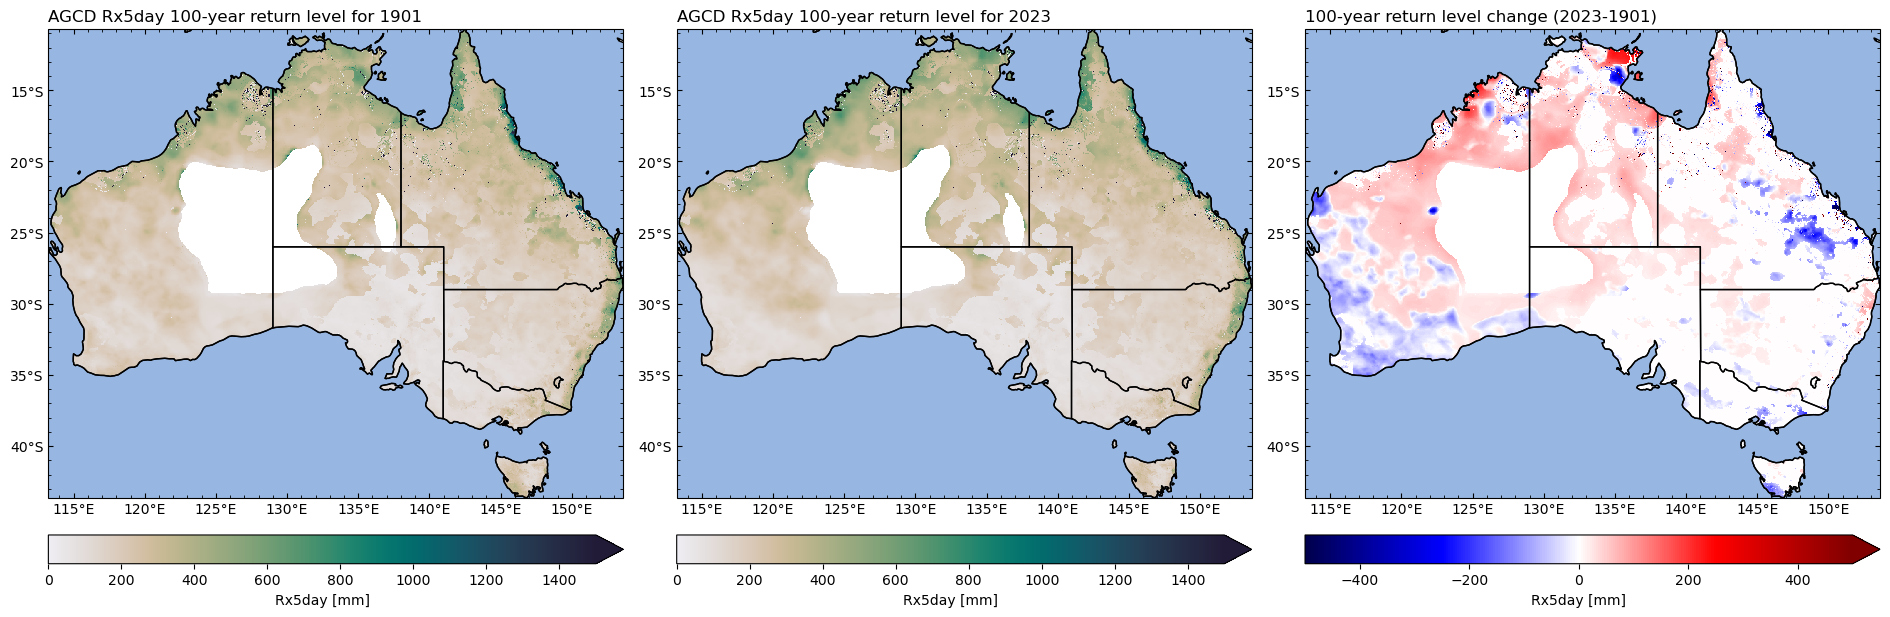

In [211]:
year = rl.time.values
fig, ax = plt.subplots(1, 3, figsize=(19, 10), subplot_kw=dict(projection=ccrs.PlateCarree()))

for i, t in enumerate(year):
    ax[i].add_feature(cartopy.feature.STATES, zorder=10)
    ax[i] = plot_aus_map(
        ax[i],
        rl.isel(time=i).where(theta.isel(theta=3) > 0),
        title=f"AGCD Rx5day 100-year return level for {t}",
        label="Rx5day [mm]",
        cbar_kwargs=dict(orientation="horizontal", fraction=0.034, extend="max", pad=0.04),
        cmap=cmocean.cm.rain,
        vmin=0,
        vmax=1500
    )

ax[2].add_feature(cartopy.feature.STATES, zorder=10)
ax[2] = plot_aus_map(
    ax[2],
    rl.isel(time=1, drop=1) - rl.isel(time=0, drop=1),
    title=f"100-year return level change ({year[1]}-{year[0]})",
    label="Rx5day [mm]",
    cbar_kwargs=dict(orientation="horizontal", fraction=0.034, extend="max", pad=0.04),
    cmap=plt.cm.seismic,
    vmin=-500,
    vmax=500
)
plt.tight_layout()
plt.savefig(home / f"figures/rx5day_AGCD-CSIRO_100-year_trends_{method}.png", dpi=200)

In [50]:
%time
ds = ds.pr.where(mask != 0)
data = ds.dropna("time", how="all").dropna("lat", how="all").dropna("lon", how="all")

theta_stationary = fit_gev(
    data,
    stationary=True,
    generate_estimates=True,
    check_fit=True,
)
theta_stationary

CPU times: user 4 µs, sys: 4 µs, total: 8 µs
Wall time: 23.6 µs


<xarray.DataArray 'pr' (lat: 641, lon: 808, theta: 3)>
dask.array<transpose, shape=(641, 808, 3), dtype=float64, chunksize=(641, 808, 3), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 -43.6 -43.55 -43.5 -43.45 ... -10.85 -10.8 -10.75
  * lon      (lon) float32 113.2 113.3 113.3 113.4 ... 153.4 153.5 153.6 153.6
Dimensions without coordinates: theta

In [ ]:
rls = get_return_levels(1/100, theta_stationary, t=None, stationary=True)
rls
fig, ax = plt.subplots(1, 1, figsize=(10, 7), subplot_kw=dict(projection=ccrs.PlateCarree()))
ax.add_feature(cartopy.feature.STATES, zorder=10)
ax = plot_aus_map(
    ax,
    rls,
    title=f"AGCD Rx5day 100-year return level",
    label="Rx5day [mm]",
    cbar_kwargs=dict(orientation="horizontal", fraction=0.034, extend="max", pad=0.04),
    cmap=cmocean.cm.rain,
    vmin=0,
    vmax=1500
)


/g/data/xv83/as3189/unseen/unseen/eva.py:222: UserWarning: The data contains non-finite values.
  warnings.warn("The data contains non-finite values.")
/g/data/xv83/as3189/unseen/unseen/eva.py:286: UserWarning: Data fit failed.
  warnings.warn("Data fit failed.")


# Scripts to save files

Non-stationary GEV parameters